# Reading data

In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json

from scipy import stats

In [2]:
#%run data_pipeline.ipynb

In [3]:
# Read data
df = pd.read_csv('cache/data.csv', sep=',', index_col=0)
unclean_df = pd.read_csv('cache/unclean_data.csv', sep=',', index_col=0)

# Effect on distributions
Plotting the distributions of variables before and after data cleaning was conducted

## Main functions

### For categorical data

In [4]:
def display_cleaning_shift_plot(clean_df, unclean_df, column, display_values = None, display_only_given = False, optional_mappings = None, rotation = 90):
    """Displays the distribution of a given column in terms of nominated rows and not nominated rows for both clean and unclean data

    Args:
        clean_df: Pandas dataframe of cleaned data
        unclean_df: Pandas dataframe of uncleaned data
        column: String indicating the column the analysis is done on
        display_values: List of column values that the plot will feature
        display_only_given: boolean, if True only to plot the values given in display_values, if False, plot others gathered under "Other"
        optional_mappings: dictionary, maps values in display_values to another string if there is a need to plot another word
        rotation: int, rotation of the xlabels on the plot

    Returns:
        None
    """
    
    #Get the nominated rows from the data
    nominated_df = clean_df[clean_df['oscar_nominated'] == True]
    nominated_unclean_df = unclean_df[unclean_df['oscar_nominated'] == True]

    #Get only the relevant attribute and map the values needed
    #If no wanted values were given take all
    if (display_values == None):
        display_values = unclean_df[column].unique()


    nominated_col = nominated_df[column].apply(lambda item: item if item in display_values else 'Other')
    nominated_col_unclean = nominated_unclean_df[column].apply(lambda item: item if item in display_values else 'Other')
    
    all_movies_col = clean_df[column].apply(lambda item: item if item in display_values else 'Other')
    all_movies_col_unclean = unclean_df[column].apply(lambda item: item if item in display_values else 'Other')

    #If only need to display the ones given remove "other" from all series
    if display_only_given:
        nominated_col = nominated_col[nominated_col != 'Other']
        nominated_col_unclean = nominated_col_unclean[nominated_col_unclean != 'Other']
        all_movies_col = all_movies_col[all_movies_col != 'Other']
        all_movies_col_unclean = all_movies_col_unclean[all_movies_col_unclean != 'Other']

    #Get the counts
    nominated_df_counts = nominated_col.value_counts()
    nominated_unclean_df_counts = nominated_col_unclean.value_counts()
    
    all_movies_counts = all_movies_col.value_counts()
    all_movies_counts_unclean = all_movies_col_unclean.value_counts()

    #Merge the values before and after cleaning, sort
    merged_nominated = pd.concat([nominated_unclean_df_counts, nominated_df_counts], axis=1).fillna(0)
    merged_nominated.columns = ["unclean_count", "clean_count"]
    merged_nominated = merged_nominated.sort_index()
    
    merged_all = pd.concat([all_movies_counts_unclean, all_movies_counts], axis=1).fillna(0)
    merged_all.columns = ["unclean_count", "clean_count"]
    merged_all = merged_all.sort_index()

    #If given any value mappings for clearer display apply them
    if optional_mappings != None:
        merged_nominated = merged_nominated.rename(index=optional_mappings)
        merged_all = merged_all.rename(index=optional_mappings)

    
    # Plotting
    fig, axs = plt.subplots(1, 2, figsize=(15,5))
    fig.suptitle("Distribution of data before and after data cleaning on a log scale")
    
    merged_all.plot(kind="bar", figsize=(12, 6), color=["blue", "orange"], ax = axs[0])
    axs[0].set_title("For all actors")
    axs[0].tick_params(axis="x", rotation=rotation)
    axs[0].set_yscale("log")
    axs[0].set_ylabel("Log Scale Count")
    
    merged_nominated.plot(kind="bar", figsize=(12, 6), color=["blue", "orange"], ax = axs[1])
    axs[1].set_title("For nominated actors")
    axs[1].tick_params(axis="x", rotation=rotation)
    axs[1].set_yscale("log")
    axs[1].set_ylabel("Log Scale Count")
    
    plt.show()

### For continuous data

In [5]:
def display_cleaning_shift_plot_cont(clean_df, unclean_df, column, is_character, bins_all, bins_nominated):
    """ Displays the distribution of a given column in terms of nominated rows and not nominated rows for both clean and unclean data. Also calculates
        the Kolmogorov-Smirnov comparing the distributions before and after cleaning

    Args:
        clean_df: Pandas dataframe of cleaned data
        unclean_df: Pandas dataframe of uncleaned data
        column: String indicating the column the analysis is done on
        is_character: String, should be either "characters" or "movies" based on what the data is grouped by
    Returns:
        None
    """

    #Get the nominated rows from the data
    nominated_df = imdb_df[imdb_df['oscar_nominated'] == True]
    nominated_unclean_df = imdb_unclean_df[imdb_unclean_df['oscar_nominated'] == True]
    
    nominated_df_vals = nominated_df[[column]]
    nominated_unclean_df_vals = nominated_unclean_df[[column]].dropna()
    
    all_df_vals = imdb_df[[column]]
    all_unclean_df_vals = imdb_unclean_df[[column]].dropna()
    
    # Plotting
    fig, axs = plt.subplots(1, 2, figsize=(15,5))
    fig.suptitle("Distribution of data before and after data cleaning")
    
    axs[0].hist(all_unclean_df_vals[column], bins=bins_all, alpha= 0.7, label='unclean_data', color='blue')
    axs[0].hist(all_df_vals[column], bins=bins_all, alpha= 0.7, label='cleaned_data', color='orange')
    axs[0].set_title("For all " + is_character)
    axs[0].set_ylabel("Frequency")
    axs[0].legend()
    
    axs[1].hist(nominated_unclean_df_vals[column], bins=bins_nominated, alpha= 0.7, label='unclean_data', color='blue')
    axs[1].hist(nominated_df_vals[column], bins=bins_nominated, alpha= 0.7, label='cleaned_data', color='orange')
    axs[1].set_title("For nominated " + is_character)
    axs[1].set_ylabel("Frequency")
    axs[1].legend()
    
    plt.show()
    
    #Aditionally, do the kolmogorov smirnoff test for the distributions before and after 
    stat, p_value = stats.kstest(all_df_vals[column].values, all_unclean_df_vals[column].values)
    print(f"Kolmogorov-Smirnov test for the {column} distributions before and after data cleaning for all data")
    print(f"Statistic: {stat} ; p-value: {p_value}")
    print()
    stat, p_value = stats.kstest(nominated_df_vals[column].values, nominated_unclean_df_vals[column].values)
    print(f"Kolmogorov-Smirnov test for the {column} distributions before and after data cleaning for nominated data")
    print(f"Statistic: {stat} ; p-value: {p_value}")

## Country

In [6]:
#Create copies for handling country data
country_df = df.copy()
country_unclean_df = unclean_df.copy()

#Fix apostrophes in countries column
country_df['countries'] = df['countries'].apply(lambda row: row.replace("'", '"')).apply(json.loads)
country_unclean_df['countries'] = unclean_df['countries'].apply(lambda row: row.replace("'", '"')).apply(json.loads)

#Extract all countries associated to a given movie
country_df = country_df.explode(column='countries').rename(columns={'countries':'country'}).reset_index()
country_unclean_df = country_unclean_df.explode(column='countries').rename(columns={'countries':'country'}).reset_index()

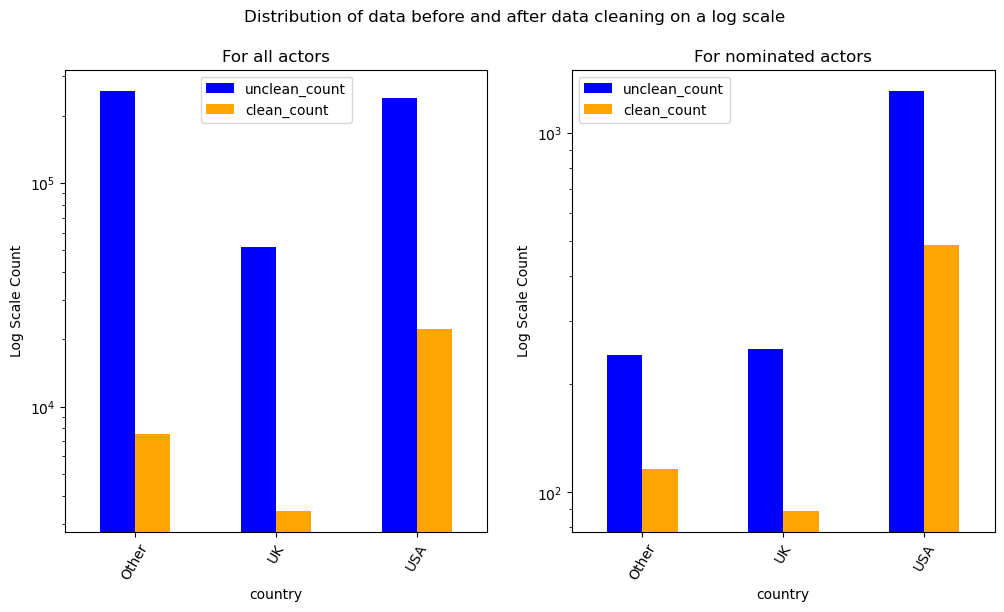

In [7]:
display_cleaning_shift_plot(country_df, country_unclean_df, "country", ['United States of America', 'United Kingdom'],False, {'United States of America': 'USA', 'United Kingdom' : 'UK'}, rotation = 60)

In [8]:
#display_cleaning_shift_plot(country_df, country_unclean_df, "country", ['United States of America', 'United Kingdom'],True, {'United States of America': 'USA', 'United Kingdom' : 'UK'})

As seen in this plot, cleaning the data has a pretty significant effect on the distribution of data, in terms of the presence of nominated movies. Before cleaning, the number of movies from other countries was comparable to the number of movies from USA. After cleaning this was no longer true.

Looking at the nominated movies, the number of nominated movies from other countries or the UK never compared to the number of nominated movies from the US.

In conclusion, this means that the data cleaning process targets more the group of movies that are unnominated and from countries other than the US.

**Note** for others, if you have made it this far congratulations, it is also interesting to check these plots without the axs[1].set_yscale("log"), as then the change is even more dramatic. Just that the number of "others" remaining after is so small that the plot is less readable

## Ethnicity

In [9]:
#reversed_map = {item: key for key, item in ethnicity_map.items()}
ethnicity_map = {
 '/m/0dryh9k': 'Indian',
 '/m/0x67': 'Black',
 '/m/041rx': 'Jewish',
 '/m/02w7gg': 'English',
 '/m/033tf_': 'Irish_Americans',
 '/m/0xnvg': 'Italian_Americans',
 '/m/02ctzb': 'White_people',
 '/m/07hwkr': 'White_Americans',
 '/m/07bch9': 'Scottish_Americans',
 '/m/03bkbh': 'Irish_people',
 '/m/0d7wh': 'British',
 '/m/03ts0c': 'French',
 '/m/0222qb': 'Italians',
 '/m/01rv7x': 'Tamil'
}
 # '???' : '/m/044038p', Could not find what this 

In [10]:
#Create copies for handling ethnicity data
ethnicity_df = df.copy()
ethnicity_unclean_df = unclean_df.copy()

#Map the known map values, "Other" if we don't know
ethnicity_df['actor_ethnicity'] = ethnicity_df['actor_ethnicity'].map(ethnicity_map).fillna("Other")
ethnicity_unclean_df['actor_ethnicity'] = ethnicity_unclean_df['actor_ethnicity'].map(ethnicity_map).fillna("Other")

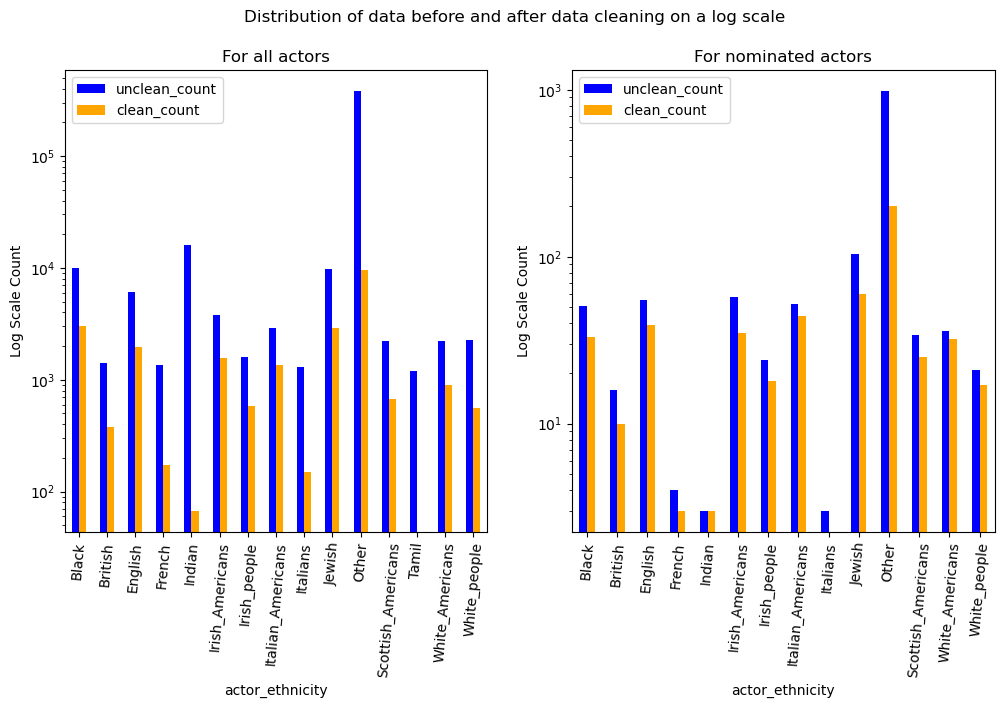

In [11]:
display_cleaning_shift_plot(ethnicity_df, ethnicity_unclean_df, 'actor_ethnicity', rotation = 85)

In is noteworthy, that for both all actors and nominated actors the largest unkiwn group before and after dropping is "other".

In terms of ethnicity diversity, most nominated movies only suffer a small dropoff of ethnical diversity. 
However, considering all movies, indian actors which represented the biggest knows ethnicity of actors suffers a big dropoff. There are no known Tamil actors left after dropping the values. A lot of data on French and Italian actors is also lost.

In conclusion while the data cleaning generally has a small impact, some ethnicities suffer a lot. This indicates that the data we are using may already be biased against some groups

## IMDb ratings

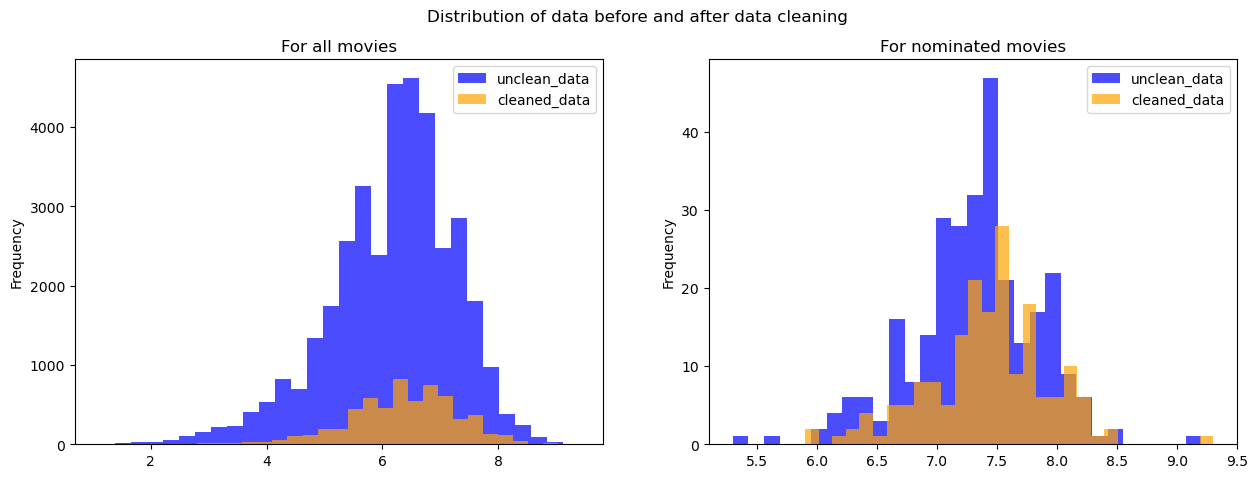

Kolmogorov-Smirnov test for the average_rating distributions before and after data cleaning for all data
Statistic: 0.06466859082056678 ; p-value: 3.6181498304960617e-19

Kolmogorov-Smirnov test for the average_rating distributions before and after data cleaning for nominated data
Statistic: 0.10274894271434064 ; p-value: 0.1762379219985301


In [12]:
imdb_df = df.drop_duplicates(subset='movie_identifier', keep='first')
imdb_unclean_df = unclean_df.drop_duplicates(subset='movie_identifier', keep='first')

display_cleaning_shift_plot_cont(imdb_df, imdb_unclean_df, "average_rating", "movies", 30, 30)

The Kolmogorov-Smirnov indicates that for all the movies dropping the NaN values significantly changed the distributions rating, but for the distribution of ratings for nominated movies it did not. This is in tune with our previous notes that dropping data mostly "hurts" the general data but not necessarily the target group we are researching.

The distributions being different for all data however do not seem too significant with the eye. The rating distributions for both similarly peak around 7.

## Height

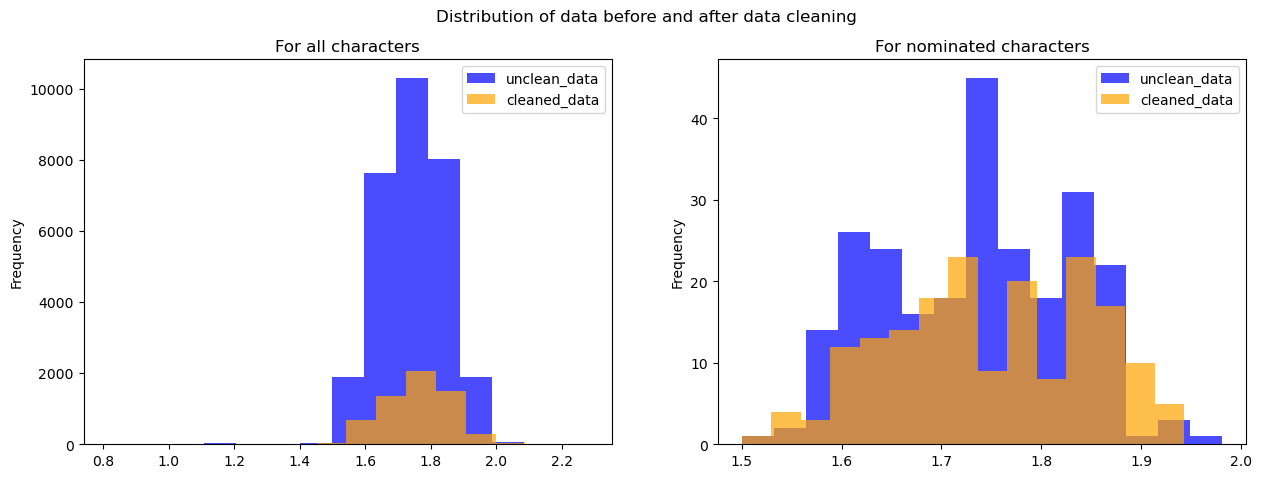

Kolmogorov-Smirnov test for the actor_height distributions before and after data cleaning for all data
Statistic: 0.057308988505957614 ; p-value: 1.088175318344285e-14

Kolmogorov-Smirnov test for the actor_height distributions before and after data cleaning for nominated data
Statistic: 0.08468834688346884 ; p-value: 0.4162434126307902


In [13]:
display_cleaning_shift_plot_cont(df, unclean_df, 'actor_height', "characters", 15, 15)

Again, the Kolmogorov-Smirnov indicates that for all the movies dropping the NaN values significantly changed the distributions rating, but for the distribution of ratings for nominated movies it did not.

## Age

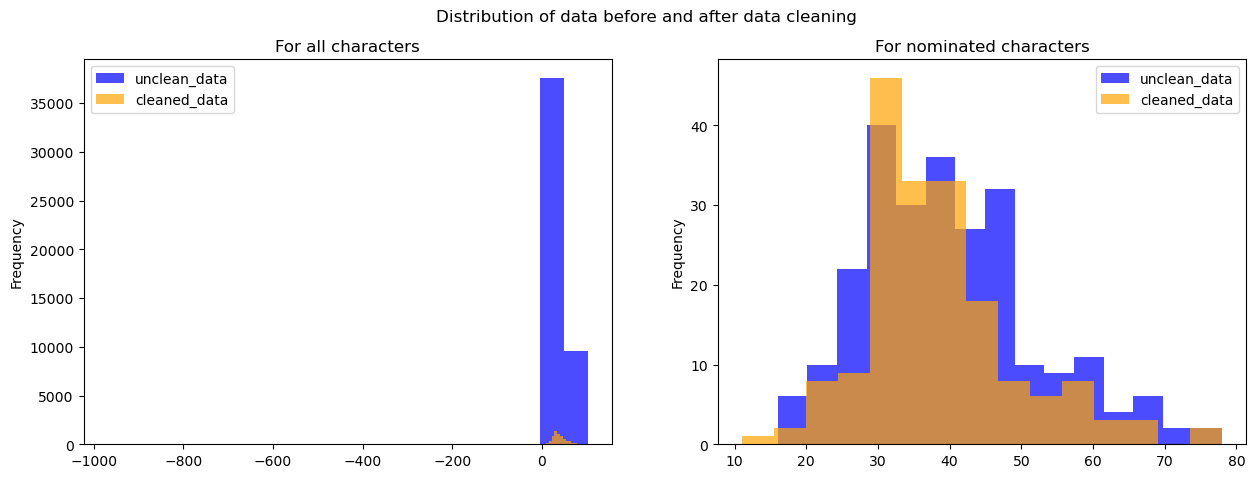

Kolmogorov-Smirnov test for the actor_age distributions before and after data cleaning for all data
Statistic: 0.03334890095117887 ; p-value: 1.4322659211961388e-05

Kolmogorov-Smirnov test for the actor_age distributions before and after data cleaning for nominated data
Statistic: 0.09977507872244715 ; p-value: 0.23073120059572777


In [14]:
display_cleaning_shift_plot_cont(df, unclean_df, 'actor_age', "characters", 20, 15)

Unclean data seems to have negative values, for nominated data the distribution does not change

## Gender

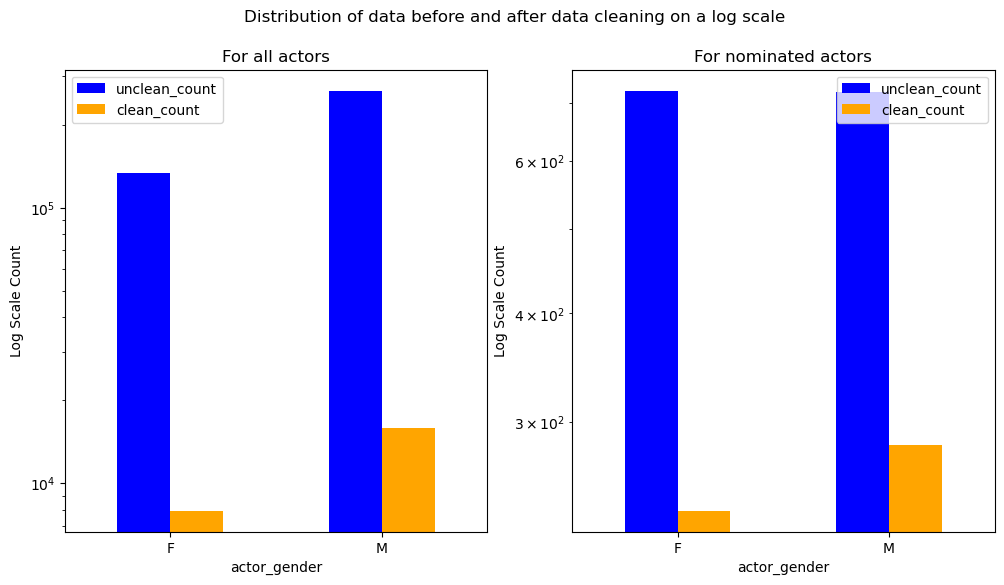

In [15]:
display_cleaning_shift_plot(df, unclean_df, 'actor_gender',['M', 'F'], True, rotation = 0)

The cleaning removes more female actors than male actors. Since the oscar nominations are gendered this will not affect the research too much

## Year

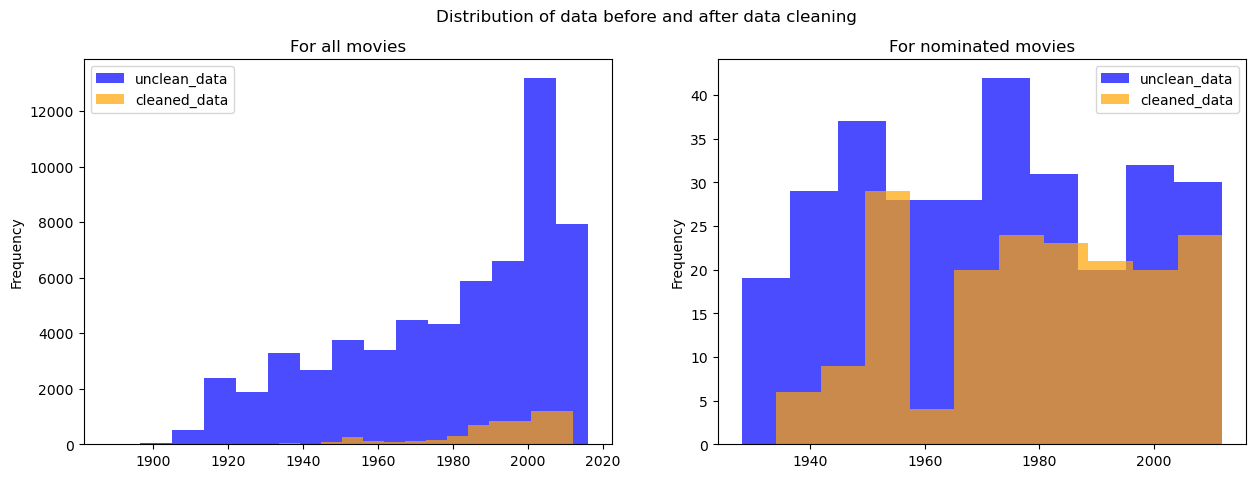

Kolmogorov-Smirnov test for the year distributions before and after data cleaning for all data
Statistic: 0.2668500148003006 ; p-value: 0.0

Kolmogorov-Smirnov test for the year distributions before and after data cleaning for nominated data
Statistic: 0.17552552552552553 ; p-value: 0.0017070034312601594


In [16]:
#To count each movie only once
year_df = df.drop_duplicates(subset='movie_identifier', keep='first')
year_unclean_df = unclean_df.drop_duplicates(subset='movie_identifier', keep='first')

display_cleaning_shift_plot_cont(year_df, year_unclean_df, 'year', "movies", 15, 10)

Removing NaNs alters the distribution of year values for both all the data and nominated data significantly

## Genres

In [17]:
#Create copies for handling country data
genres_df = df.copy()
genres_unclean_df = unclean_df.copy()

#Fix apostrophes in countries column
genres_df['genres'] = df['genres'].apply(lambda row: row.replace("'", '"')).apply(json.loads)
genres_unclean_df['genres'] = unclean_df['genres'].apply(lambda row: row.replace("'", '"')).apply(json.loads)

#Extract all countries associated to a given movie
genres_df = genres_df.explode(column='genres').rename(columns={'genres':'genre'}).reset_index()
genres_unclean_df = genres_unclean_df.explode(column='genres').rename(columns={'genres':'genre'}).reset_index()

#As there appear some movies with genre "," which is not valid, drop those rows
genres_df = genres_df[genres_df['genre'].str.strip() != ","]
genres_unclean_df = genres_unclean_df[genres_unclean_df['genre'].str.strip() != ","]

In [18]:
#Print the most popular genres to plot only them
genres_df['genre'].value_counts()[:10].index

Index(['Drama', 'Comedy', 'Thriller', 'Action', 'Romance Film',
       'Crime Fiction', 'Adventure', 'Romantic comedy', 'Family Film',
       'Indie'],
      dtype='object', name='genre')

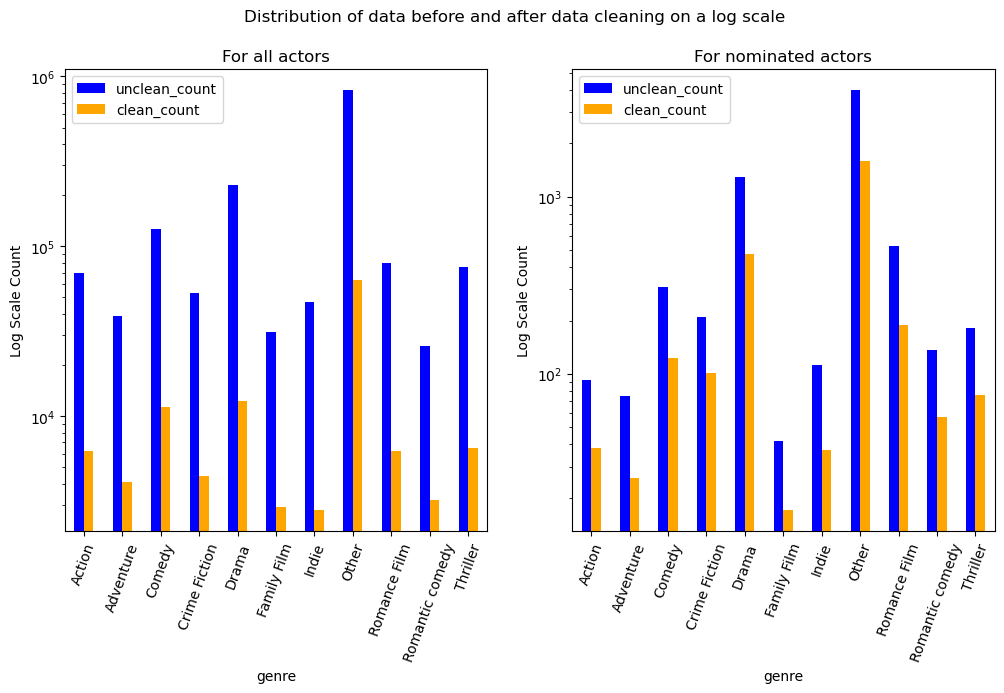

In [19]:
display_cleaning_shift_plot(genres_df, genres_unclean_df, "genre", 
        ['Drama', 'Comedy', 'Thriller', 'Action', 'Romance Film', 'Crime Fiction', 'Adventure', 'Romantic comedy', 'Family Film','Indie'],False, rotation = 70)